In [1]:
%pip install -q python-dotenv haystack-ai

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import urllib.request
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(Path(Path.cwd().parent.parent.parent, ".env"))

True

In [10]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder, OpenAITextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

urllib.request.urlretrieve("https://www.wikiwand.com/de/articles/Leonardo_da_Vinci")    

document_store = InMemoryDocumentStore()

text_file_converter = TextFileToDocument()
cleaner = DocumentCleaner()
splitter = DocumentSplitter()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("converter", text_file_converter)
indexing_pipeline.add_component("cleaner", cleaner)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "cleaner.documents")
indexing_pipeline.connect("cleaner.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")
indexing_pipeline.run(data={"sources": ["davinci.txt"]})

text_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store)
template = """Given these documents, answer the question.
              Documents:
              {% for doc in documents %}
                  {{ doc.content }}
              {% endfor %}
              Question: {{query}}
              Answer:"""
prompt_builder = PromptBuilder(template=template)
llm = OpenAIGenerator()

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")


Calculating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [11]:
query = "How old was Leonardo when he died?"
result = rag_pipeline.run(data={"prompt_builder": {"query":query}, "text_embedder": {"text": query}})
print(result["llm"]["replies"][0])

Leonardo da Vinci was born on April 15, 1452, and died on May 2, 1519. Therefore, he was 67 years old when he died.


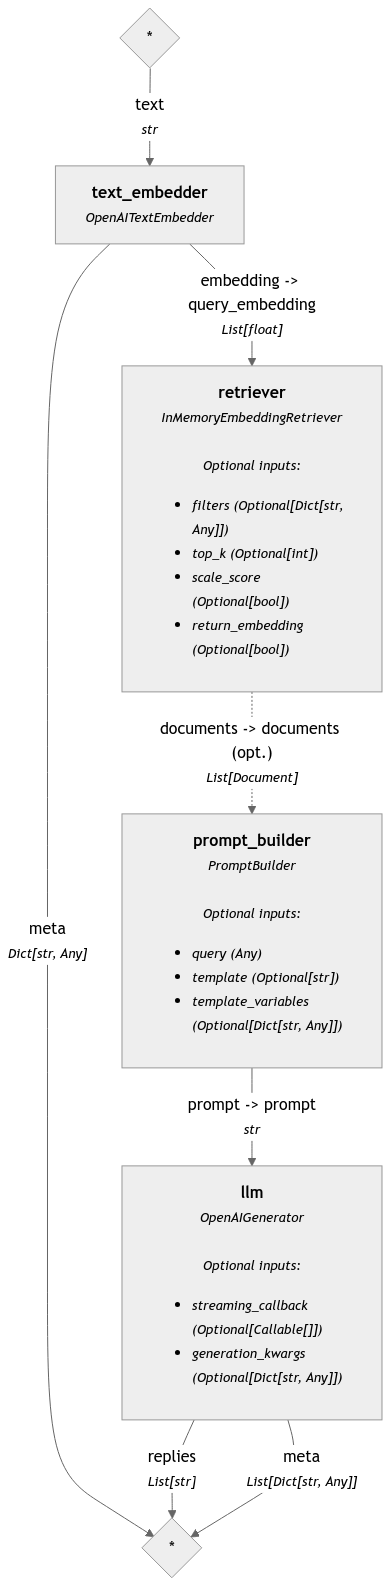

In [12]:
rag_pipeline.show()